In [35]:
import numba
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display

## Récupération des données

In [36]:
columns = ["Date", "Heure", "SG Hauteur", "SG Ectype", "SG Q", "SN Hauteur", "SN Ectype", "SN Q",
          "Montoir Hauteur", "Montoir Ectype", "Montoir Q", "Paimboeuf Hauteur", "Paimboeuf Ectype", "Paimboeuf Q",
          "Cordemais Hauteur", "Cordemais Ectype", "Cordemais Q", "LP Hauteur", "LP Ectype", "LP Q",
          "NUB Hauteur", "NUB Ectype", "NUB Q", "NSAL Hauteur", "NSAL Ectype", "NSAL Q", "SG Patm", "Nantes Patm"]

chunks = pd.read_csv("Datas/X_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
X = pd.DataFrame()
for chunk in chunks:
    X = pd.concat((X,chunk))

print(X)
X.pop('Date')

                       Date  SN Hauteur (t-36)  SN Hauteur (t-35)  \
36      2012-01-01 03:00:00               3.96               3.94   
37      2012-01-01 03:05:00               3.94               3.93   
38      2012-01-01 03:10:00               3.93               3.91   
39      2012-01-01 03:15:00               3.91               3.89   
40      2012-01-01 03:20:00               3.89               3.87   
...                     ...                ...                ...   
418592  2015-12-24 17:45:00               5.63               5.66   
418593  2015-12-24 17:50:00               5.66               5.68   
418594  2015-12-24 17:55:00               5.68               5.73   
418595  2015-12-24 18:00:00               5.73               5.76   
418596  2015-12-24 18:05:00               5.76               5.79   

        SN Hauteur (t-34)  SN Hauteur (t-33)  SN Hauteur (t-32)  \
36                   3.93               3.91               3.89   
37                   3.91            

36        2012-01-01 03:00:00
37        2012-01-01 03:05:00
38        2012-01-01 03:10:00
39        2012-01-01 03:15:00
40        2012-01-01 03:20:00
                 ...         
418592    2015-12-24 17:45:00
418593    2015-12-24 17:50:00
418594    2015-12-24 17:55:00
418595    2015-12-24 18:00:00
418596    2015-12-24 18:05:00
Name: Date, Length: 396026, dtype: object

In [37]:
chunks = pd.read_csv("Datas/Y_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
Y = pd.DataFrame()
for chunk in chunks:
    Y = pd.concat((Y,chunk))

print(Y)
Y.pop('Date')

                       Date  SN Hauteur (t)  SN Hauteur (t+1)  \
36      2012-01-01 03:00:00            2.49              2.45   
37      2012-01-01 03:05:00            2.45              2.40   
38      2012-01-01 03:10:00            2.40              2.37   
39      2012-01-01 03:15:00            2.37              2.33   
40      2012-01-01 03:20:00            2.33              2.30   
...                     ...             ...               ...   
418592  2015-12-24 17:45:00            5.34              5.27   
418593  2015-12-24 17:50:00            5.27              5.22   
418594  2015-12-24 17:55:00            5.22              5.16   
418595  2015-12-24 18:00:00            5.16              5.09   
418596  2015-12-24 18:05:00            5.09              5.03   

        SN Hauteur (t+2)  SN Hauteur (t+3)  SN Hauteur (t+4)  SN Hauteur (t+5)  
36                  2.40              2.37              2.33              2.30  
37                  2.37              2.33              2

36        2012-01-01 03:00:00
37        2012-01-01 03:05:00
38        2012-01-01 03:10:00
39        2012-01-01 03:15:00
40        2012-01-01 03:20:00
                 ...         
418592    2015-12-24 17:45:00
418593    2015-12-24 17:50:00
418594    2015-12-24 17:55:00
418595    2015-12-24 18:00:00
418596    2015-12-24 18:05:00
Name: Date, Length: 396026, dtype: object

### Longueur d'entrée et de sortie

In [38]:
# Ces longueurs sont définies par les fichiers .csv
input_length = 36
output_length = 6

### Réorganisation des données

In [39]:
# Input features
Nb_features = int(X.shape[1]/input_length)
print(f"Number of features : {Nb_features}")

Nb_labels = int(Y.shape[1]/output_length)
print(f"Number of Label : {Nb_labels}")

Number of features : 1
Number of Label : 1


In [40]:
print(X.head)
print(Y.head)

print(X.columns, Y.columns)

X_datas = X.values
X_datas = X_datas.reshape((X.shape[0], input_length, Nb_features), order = 'F')
Y_datas = Y.values
Y_datas = Y_datas.reshape((Y.shape[0], output_length, Nb_labels), order ='F')

<bound method NDFrame.head of         SN Hauteur (t-36)  SN Hauteur (t-35)  SN Hauteur (t-34)  \
36                   3.96               3.94               3.93   
37                   3.94               3.93               3.91   
38                   3.93               3.91               3.89   
39                   3.91               3.89               3.87   
40                   3.89               3.87               3.85   
...                   ...                ...                ...   
418592               5.63               5.66               5.68   
418593               5.66               5.68               5.73   
418594               5.68               5.73               5.76   
418595               5.73               5.76               5.79   
418596               5.76               5.79               5.80   

        SN Hauteur (t-33)  SN Hauteur (t-32)  SN Hauteur (t-31)  \
36                   3.91               3.89               3.87   
37                   3.89      

In [41]:
n = len(X_datas)
# Train dataset
X_train = X_datas[:int(0.7*n)]
Y_train = Y_datas[:int(0.7*n)]

# Validation dataset
X_val = X_datas[int(0.7*n):int(0.9*n)]
Y_val = Y_datas[int(0.7*n):int(0.9*n)]

# Test dataset
X_test = X_datas[int(0.9*n):]
Y_test = Y_datas[int(0.9*n):]

X_train

array([[[3.96],
        [3.94],
        [3.93],
        ...,
        [2.62],
        [2.57],
        [2.53]],

       [[3.94],
        [3.93],
        [3.91],
        ...,
        [2.57],
        [2.53],
        [2.49]],

       [[3.93],
        [3.91],
        [3.89],
        ...,
        [2.53],
        [2.49],
        [2.45]],

       ...,

       [[4.81],
        [4.82],
        [4.82],
        ...,
        [3.81],
        [3.74],
        [3.66]],

       [[4.82],
        [4.82],
        [4.82],
        ...,
        [3.74],
        [3.66],
        [3.6 ]],

       [[4.82],
        [4.82],
        [4.82],
        ...,
        [3.66],
        [3.6 ],
        [3.52]]])

In [43]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

TypeError: 'list' object is not callable

### Création du modèle

In [44]:
multi_conv_model = tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3), input_shape = (input_length, Nb_features)),
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 34, 32)            128       
                                                                 
 flatten_1 (Flatten)         (None, 1088)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 6534      
                                                                 
 reshape_2 (Reshape)         (None, 6, 1)              0         
                                                                 
Total params: 6,662
Trainable params: 6,662
Non-trainable params: 0
_________________________________________________________________


In [45]:
multi_lstm_model =  tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.LSTM(256, activation='tanh', input_shape = (input_length, Nb_features)),
    #tf.keras.layers.Dropout(0.2),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
 reshape_3 (Reshape)         (None, 6, 1)              0         
                                                                 
Total params: 265,734
Trainable params: 265,734
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')


multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])


### Entrainement

In [47]:
MAX_EPOCHS = 5
history = multi_lstm_model.fit(X_train, Y_train, epochs=MAX_EPOCHS, callbacks=[early_stopping], batch_size = 1024, validation_data=(X_val, Y_val))

Epoch 1/5


2023-02-16 13:49:43.352268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 13:49:43.590678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 13:49:44.725305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - ETA: 0s - loss: 2.1224 - mean_absolute_error: 1.0753

2023-02-16 13:50:47.382088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 13:50:47.475958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 72s 258ms/step - loss: 2.1224 - mean_absolute_error: 1.0753 - val_loss: 1.3942 - val_mean_absolute_error: 0.8447
Epoch 2/5
271/271 [==============================] - 66s 242ms/step - loss: 0.3462 - mean_absolute_error: 0.2426 - val_loss: 1.1578 - val_mean_absolute_error: 0.8047
Epoch 3/5
271/271 [==============================] - 63s 232ms/step - loss: 0.2741 - mean_absolute_error: 0.1271 - val_loss: 0.9198 - val_mean_absolute_error: 0.6614
Epoch 4/5
271/271 [==============================] - 65s 240ms/step - loss: 0.2614 - mean_absolute_error: 0.0946 - val_loss: 0.8078 - val_mean_absolute_error: 0.5768
Epoch 5/5
271/271 [==============================] - 70s 258ms/step - loss: 0.2569 - mean_absolute_error: 0.0838 - val_loss: 0.7848 - val_mean_absolute_error: 0.5575


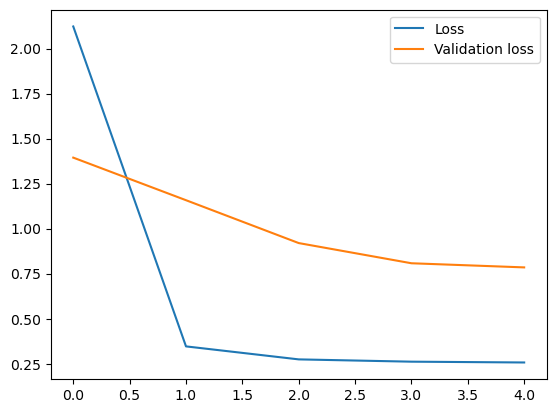

In [48]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation loss")

plt.legend()
plt.show()

In [49]:
multi_lstm_model.save("models/MultiLSTM", save_format="h5")

In [50]:
multi_lstm_model.evaluate(X_test, Y_test)

1238/1238 [==============================] - 17s 13ms/step - loss: 0.1387 - mean_absolute_error: 0.3522


[0.13868968188762665, 0.3521731197834015]

In [51]:
test = np.array([X_train[0]])
real = np.array([Y_train[0]])
test

array([[[3.96],
        [3.94],
        [3.93],
        [3.91],
        [3.89],
        [3.87],
        [3.85],
        [3.82],
        [3.79],
        [3.76],
        [3.72],
        [3.7 ],
        [3.67],
        [3.63],
        [3.59],
        [3.56],
        [3.52],
        [3.46],
        [3.41],
        [3.38],
        [3.33],
        [3.27],
        [3.23],
        [3.18],
        [3.12],
        [3.07],
        [3.01],
        [2.95],
        [2.89],
        [2.83],
        [2.77],
        [2.72],
        [2.66],
        [2.62],
        [2.57],
        [2.53]]])

In [52]:
pred = multi_lstm_model.predict(test)

2023-02-16 13:55:36.384236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 13:55:36.465161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 492ms/step


In [53]:
pred

array([[[1.9925979],
        [2.0076718],
        [2.0212379],
        [2.0519454],
        [2.0804424],
        [2.1078942]]], dtype=float32)

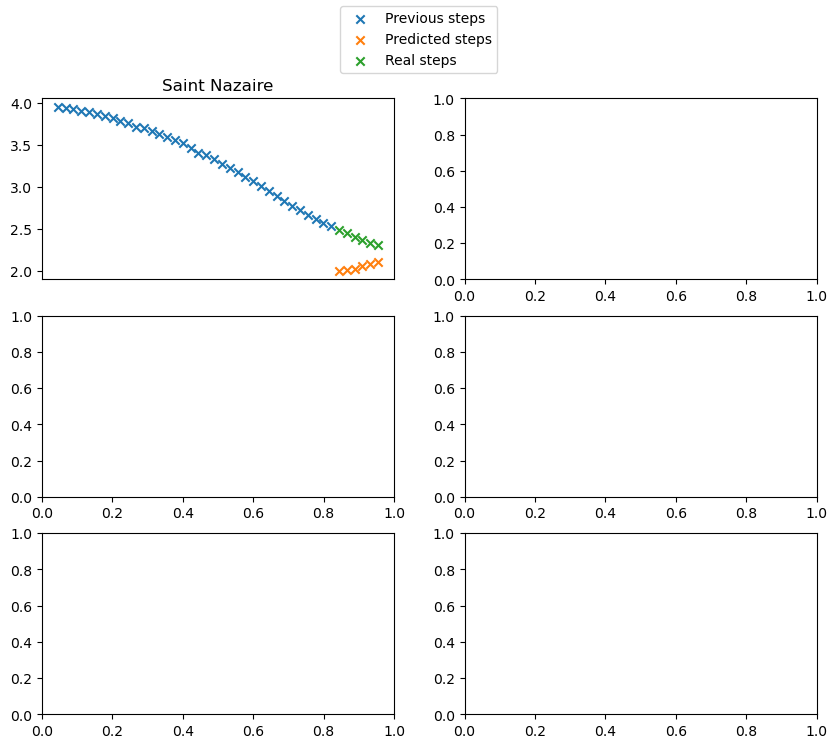

In [54]:
ports =["Saint Nazaire", "Montoir", "Paimboeuf", "Cordemais", "Le Pellerin", "Nantes - UB"]
abs = [i for i in range(input_length+output_length)]
fig, axs = plt.subplots(3,2, figsize = (10,8))
axs = axs.reshape([axs.shape[0]*axs.shape[1]])
for ax,i in zip(axs,range(pred.shape[2])):
    ax.set_title(ports[i])
    ax.get_xaxis().set_visible(False)
    ax.scatter(abs[:input_length], test[0,:,i], label = "Previous steps", marker="x")
    ax.scatter(abs[input_length:], pred[0,:,i], label = "Predicted steps", marker="x")
    ax.scatter(abs[input_length:], real[0,:,i], label = "Real steps", marker="x")

handles, labels = ax.get_legend_handles_labels()

# plt.subplot(2,1,1)
# plt.plot()


fig.legend(handles, labels, loc='upper center')
plt.show()
fig.savefig("Predictions2.png")